# Imports

In [242]:
import pandas as pd
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import train_test_split,GridSearchCV, HalvingGridSearchCV, ParameterGrid

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    mean_squared_error,
    RocCurveDisplay,
    make_scorer,
    r2_score
)
from sklearn import preprocessing

import matplotlib.pyplot as plt
import xgboost as xg
import numpy as np

# Helpers

In [243]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Preprocessing

In [244]:
sector_return = pd.read_csv('s3://fintech540-ml/staging/transform/SECTOR_30T.csv')

In [245]:
gas = pd.read_csv('s3://fintech540-ml/external/weekly-gasoline.csv')
gas.columns = ['gas_' + x.lower().replace(' ', '_') for x in gas.columns]

In [246]:
sector_return['ts'] = pd.to_datetime(sector_return['Date'] + ' ' + sector_return['Time-Interval'])
sector_return['week'] = sector_return['ts'].dt.isocalendar().week
sector_return['year'] = sector_return['ts'].dt.year

sector_return = sector_return.drop(['Date', 'Time-Interval', 'ts'], axis=1)

/var/folders/yn/44g9c8092hs_wb4_5rjgbb300000gn/T/ipykernel_50982/2754285845.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sector_return['ts'] = pd.to_datetime(sector_return['Date'] + ' ' + sector_return['Time-Interval'])


In [247]:
merged_df = (pd.merge(sector_return, gas, left_on=['week', 'year'], right_on=['gas_fiscal_week', 'gas_fiscal_year'])
                .drop(['year', 'week', 'gas_fiscal_year', 'gas_fiscal_week'], axis=1))

merged_df['gas_difference_from_same_week_last_year'] = pd.to_numeric(merged_df['gas_difference_from_same_week_last_year'].str.replace(',', ''), errors='coerce')
merged_df['gas_cumulative_difference'] = pd.to_numeric(merged_df['gas_cumulative_difference'].str.replace(',', ''), errors='coerce')

merged_df = merged_df.dropna()

In [248]:
le = preprocessing.LabelEncoder()

merged_df['Sector'] = le.fit_transform(merged_df['Sector'])

# Training

In [249]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(columns='Top_Sector'), merged_df['Top_Sector'], stratify=merged_df['Top_Sector'], random_state=42, test_size=.2)

In [250]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [251]:
xgbr = xg.XGBRegressor(random_state=42)

param_grid_xg = {
    'n_estimators': [850],
    'learning_rate': [0.1, 0.2, 0.25],
    'reg_alpha': range(3),
    'min_child_weight': range(3),
    'max_depth': [5],
    
}

search = HalvingGridSearchCV(estimator=xgbr, param_grid=param_grid_xg, cv=5, scoring=rmse_scorer, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

best_params = search.best_params_
best_estimator = search.best_estimator_

y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

new_row = pd.DataFrame({
    'train_rmse': [train_rmse],
    'train_r2': [train_r2],
    'test_rmse': [test_rmse],
    'test_r2': [test_r2],
    'best_params': [best_params]
})

print(f"train_rmse: {train_rmse} train_r2: {train_r2}")
print(f"test_rmse: {test_rmse} test_r2: {test_r2}")
print(best_params)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1100
max_resources_: 29702
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 1100
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 9
n_resources: 3300
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 9900
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 1
n_resources: 29700
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_rmse: 0.3016632440545038 train_r2: 0.3447595703778742
test_rmse: 0.3422591435977468 test_r2: 0.1567641567760254
{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 850, 'reg_alpha': 2}


# Feature importance

<Axes: >

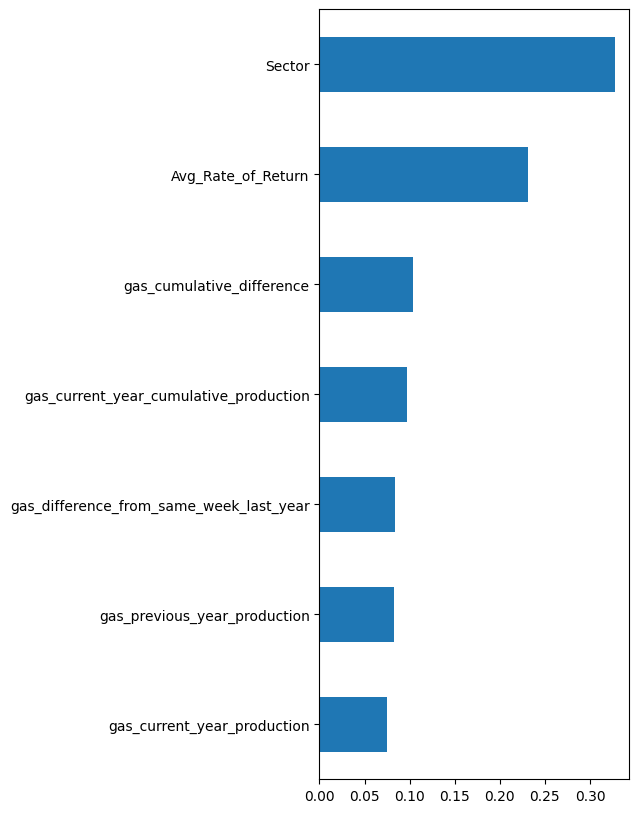

In [252]:
(pd.Series(best_estimator.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(figsize=(4, 10))
)